# Predicting the S&P500 with Recurrent Neural Networks

### Outline
Recurrent neural networks are a special type of deep neural networks for learning outcomes where future predictions are linked to past events. The S&P 500 is a stock market index that tracks the performance of the 500 largest companies that are listed on stock exchanges in the United States. We may observe that the future price (in this case closing price) of an underlying (in this case, the S&P) may be linked to the past market data such as the previous high, low, opening and closing price of the underlying and the volume of trades made per day. Other information that affect the market in the past may also be contributing factors. In this project, we frame predicting the future closing price of the S&P 500 as a sequence problem. Hence, we use recurrent neural networks to build an approximation model for a multivariate time-series problem.

### Data source
Data is from YahooFinance (https://finance.yahoo.com/quote/%5EGSPC/history/).
90 Year Historical S&P 500 Index data since 1927. From December 30th 1927 to February 23rd 2021.
Historical data is inflation-adjusted using the headline CPI and each data point represents the month-end closing value. The current month is updated on an hourly basis with today's latest value. The current price of the S&P 500 as of February 23, 2021 is 3,881.37.

### Model

In [1]:
# imports
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

#### Load the data

In [3]:
data = pd.read_csv('data/GSPC.csv')

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


In [5]:
# set Date as index column
data = data.set_index('Date')

#### Process the data

In [6]:
# add next days closing (target)
data['next_day_close'] = data['Close'].shift(-1)

In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,next_day_close
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,17.500000


In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,next_day_close
Date,,,,,,,
2021-02-17,3918.500000,3933.610107,3900.429932,3931.330078,3931.330078,4718280000,3913.969971
2021-02-18,3915.860107,3921.979980,3885.030029,3913.969971,3913.969971,4773430000,3906.709961
2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,3876.500000
2021-02-22,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,3881.370117
2021-02-23,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,NaN


In [9]:
# remove NaNs
data.dropna(axis=0, inplace=True)

# drop  Adji Close
data.drop(columns='Adj Close', inplace=True)

print(data.shape)

(23396, 6)


#### Modelling preparation

In [10]:
# split in training and evaluation set
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)

In [11]:
# split train/ test
train_X, train_y = data_train.values[:, :-1], data_train.values[:, -1]
test_X, test_y = data_test.values[:, :-1], data_test.values[:, -1]

In [12]:
print(f'train_X: {train_X.shape}')
print(f'train_y: {train_y.shape}\n')

print(f'test_X: {test_X.shape}')
print(f'test_y: {test_y.shape}')

train_X: (18716, 5)
train_y: (18716,)

test_X: (4680, 5)
test_y: (4680,)


In [13]:
# FEATURE (X) MinMaxScaler - center and scale the dataset
scaler_train_X = MinMaxScaler(feature_range=(0, 1))
scaler_test_X = MinMaxScaler(feature_range=(0, 1))

In [14]:
# TARGET (y) MinMaxScaler - center and scale the dataset
scaler_train_y = MinMaxScaler(feature_range=(0, 1))
scaler_test_y = MinMaxScaler(feature_range=(0, 1))

**Scale X and reshape inputs**

In [15]:
# scale X
train_X = scaler_train_X.fit_transform(train_X)
test_X = scaler_test_X.fit_transform(test_X)

In [16]:
# reshape inputs to 3D array
train_X = train_X[:,None,:]
test_X = test_X[:,None,:]

In [17]:
print(f'train_X: {train_X.shape}')
print(f'test_X: {test_X.shape}')

train_X: (18716, 1, 5)
test_X: (4680, 1, 5)


**Reshape y and scale**

In [18]:
# reshape outputs
train_y = np.reshape(train_y, (-1,1))
test_y = np.reshape(test_y, (-1,1))

In [19]:
print(f'train_y: {train_y.shape}')
print(f'test_y: {test_y.shape}')

train_y: (18716, 1)
test_y: (4680, 1)


In [20]:
train_y = scaler_train_y.fit_transform(train_y)
test_y = scaler_test_y.fit_transform(test_y)

#### The Model

**Keras callbacks**

In [21]:
checkpoint = ModelCheckpoint('model/stock_prediction.h5',
                             monitor='loss',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)

tensorboard = TensorBoard(log_dir=f'./logs-{dt.datetime.now().strftime("%m%d%Y%H%M%S")}',
                          histogram_freq=0,
                          write_graph=False,
                          update_freq='epoch')

earlystop = EarlyStopping(monitor='loss',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='loss',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

def epoch_end(epoch, logs):
    message = f'End of epoch {str(epoch)}. Learning rate: {str(K.eval(model.optimizer.lr))}'
    os.system(f'echo {message}')

def epoch_begin(epoch, logs):
    print(f'Learning rate: {K.eval(model.optimizer.lr)}')
    
def train_begin(logs):
    os.system(f'echo Beginning training')


lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

**Build the Model**

In [22]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(12, input_shape=train_X.shape[1:],
                               return_sequences=True))
# model.add(tf.keras.layers.GRU(3 return_sequences=True))
# model.add(tf.keras.layers.GRU(2))
model.add(tf.keras.layers.Dense(1))

# compile the model
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

In [23]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 12)             684       
_________________________________________________________________
dense (Dense)                (None, 1, 1)              13        
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


In [24]:
# create dataset pipeline
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_X, train_y)).shuffle(len(train_X)).repeat().batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(batch_size)

**Train the Model**

In [25]:
# train the model
history = model.fit(train_ds, epochs=10,
                    steps_per_epoch=100, #3000, #len(train_ds),
#                     validation_data=test_ds,
#                     validation_steps=len(test_ds),
                    callbacks=[reducelr, earlystop, tensorboard, checkpoint])
#                    )

Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.0404 - mse: 0.0404WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 93/100 [==========================>...] - ETA: 0s - loss: 0.0126 - mse: 0.0126
Epoch 00001: loss improved from inf to 0.01190, saving model to model/stock_prediction.h5
100/100 [==============================] - 0s 3ms/step - loss: 0.0119 - mse: 0.0119
Epoch 2/10
 84/100 [========================>.....] - ETA: 0s - loss: 3.0350e-04 - mse: 3.0350e-04
Epoch 00002: loss improved from 0.01190 to 0.00027, saving model to model/stock_prediction.h5
100/100 [==============================] - 0s 3ms/step - loss: 2.7330e-04 - mse: 2.7330e-04
Epoch 3/10
 89/100 [=========================>....] - ETA: 0s - loss: 1.0453e-04 - mse: 1.045

**Evaluate the model**

In [26]:
# evaluate the model
loss, mse = model.evaluate(test_ds)

147/147 [==============================] - 0s 2ms/step - loss: 7.3798e-04 - mse: 7.3798e-04


In [27]:
print('Validation loss: {:.4f}'.format(loss))
print('Validation mse: {:.4f}'.format(mse))

Validation loss: 0.0007
Validation mse: 0.0007


**Visualize the model**

In [28]:
# predict
y_pred = model.predict(test_X)

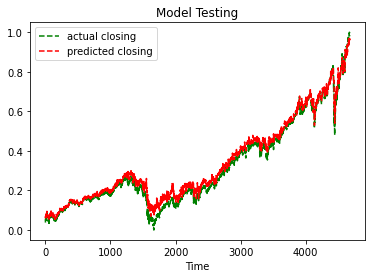

In [41]:
# plot predicted sequence
plt.title("Model Testing", fontsize=12)
plt.plot(test_y, "g--", markersize=10, label="actual closing")
plt.plot(y_pred[:,0,0], "r--", markersize=10, label="predicted closing")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

#### Predict the closing stock price for Feb 24th 2021

In [30]:
spx_24_2_2021 = np.array([3857.070068, 3895.979980, 3805.590088, 3881.370117, 6280650000])

In [31]:
# reshape
spx_24_2_2021 = np.reshape(spx_24_2_2021, (-1,1)).T
print(spx_24_2_2021)

[[3.85707007e+03 3.89597998e+03 3.80559009e+03 3.88137012e+03
  6.28065000e+09]]


In [32]:
spx_24_2_2021.shape

(1, 5)

In [33]:
# scale input
spx_24_2_2021 = scaler_train_X.transform(spx_24_2_2021)

In [34]:
# reshape inputs to 3D array
spx_24_2_2021 = spx_24_2_2021[:,None,:]

In [35]:
spx_24_2_2021.shape

(1, 1, 5)

In [36]:
stock_prediction = model.predict(spx_24_2_2021)

In [37]:
print(stock_prediction)

[[[1.7975395]]]


In [40]:
# inverse transform
prediction = scaler_train_y.inverse_transform(stock_prediction)
print(f'Closing stock price for 24th February 2021: {prediction[0][0]}')

ValueError: Found array with dim 3. Estimator expected <= 2.